# Apple Advertising on Twitter

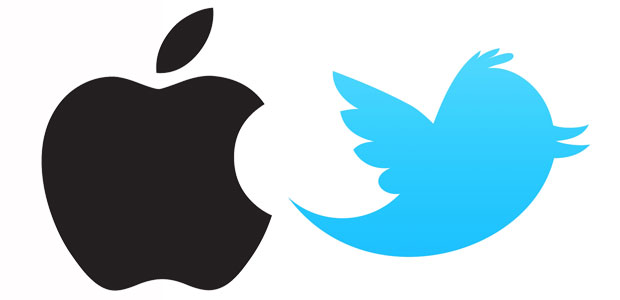


Presented by: Mustafa Furkan Kolanci, Seraj Khazei, Isaac Barrera

Date: 11/18/2021

Instructor: Angelica Spratley

github link: https://github.com/mfurkankolanci/dsc_project_4

## Overview

In this project, we are looking at user's tweets, the product in question and the sentiment toward the product. The dataset includes more than 9,000 tweets with product and sentiment information attached. This dataset is well-suited for the business problem, as the goal is to provide Apple advertising team with a model that can predict the sentiment of tweets. 

For data preparation, we first grouped all the products under two labels, Apple and Google. This was done as Apple and Google products were scattered in the dataset and had to be regrouped. Then, we used regex to get rid of unimportant characters in the tweets. After that, we tokenize the tweets to split each tweets into its respective words so that each word is a feature in the model. We also remove stopwords as they provide little to no sentiment value to the tweets. Lemmatization is performed to group words with the same meaning together as one word. TF-IDF is applied in order to assign each word in each tweet a numeric value based on its importance across all tweets. Finally, random oversampling is applied in order to eliminate the class imbalance observed in the target variable (sentiment). We used pandas to perform data filtering and visualization, nltk to perform text preprocessing, imblearn for oversampling and sklearn for TF-IDF.  

For modeling, we utilized the sklearn's LogisticRegression, DecisionTree and RandomForestClassifier methods. We tuned our models using GridSearchCV also provided by sklearn. 

Our final model has an accuracy of 63%, which means that it correctly identifies the sentiment of tweets 63% of the time. We used cross validation and the test set accuracy scores in order to validate our model performance.

## Business Understanding

As data scientists working in Twitter, we were approached by a stakeholder, Apple's advertising team. They have noticed that some Twitter users have not had positive experiences with Apple products. In order to not lose those customers, they would like to have targeted ads towards those users. Our stakeholder is also interested in tweets about Google and they would like to turn this into their advantage by converting these users into Apple customers. Therefore, they have asked our team to generate a model that performs sentiment analysis in order to categorize tweets about Apple and Google as positive, neutral and negative, so that the stakeholder knowns which users to target with their ads.

## Data Understanding

The dataset is from the year 2013 and includes more 9,000 tweets. There are three columns, the first column includes the tweet text, the second column is the subject of the tweet and third column is the emotion of the tweet. 

## Data Preparation and Text Preprocessing

Let's start by importing modules necessary for analysis and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('judge-1377884607_tweet_product_company.csv',encoding= 'unicode_escape')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


Let's convert the sentences contained in the `tweet_text` column to type `string` for later analysis.

In [3]:
df['tweet_text'] = df['tweet_text'].astype(str)

Let's also rename the columns so that they are more readable.

In [4]:
df.rename(columns={"emotion_in_tweet_is_directed_at": "product", "is_there_an_emotion_directed_at_a_brand_or_product": "emotion"},inplace=True)

We would like to classify the tweets on whether they are about Google or Apple. So, we first group all Google related `product` column values as Google and also group all Apple related `product` column values as Apple. Then, since there are many tweets that have unknown `product` values, we search for different substrings in these tweets in order to assign them to either Apple or Google categories. 

In [5]:
df["product"].fillna("none", inplace = True)
df_none = df.loc[df["product"] == 'none']

apple_condition = (df['product'] == "iPad") | (df['product'] == "iPad or iPhone App") | (df['product'] == "iPhone") | (df['product'] == "Other Apple product or service")
google_condition = (df['product'] == "Other Google product or service") | (df['product'] == "Android App") | (df['product'] == "Android") 
df.loc[apple_condition,'product'] = "Apple"
df.loc[google_condition, 'product'] = "Google"

# apple loop
for word in ["Apple","iphone","apple","ipad","ipad2","iPad 2","iPhone","iPad"]:
    temp_df = df_none[df_none['tweet_text'].str.contains(word)]
    temp_df['product'].replace({'none': 'Apple'}, inplace=True)
    df_none = temp_df.combine_first(df_none)
# google loop
for word in ["Google","google","Android","android"]:
    temp_df = df_none[df_none['tweet_text'].str.contains(word)]
    temp_df['product'].replace({'none': 'Google'}, inplace=True)
    df_none = temp_df.combine_first(df_none)
df_1 = df_none.combine_first(df)

Next, drop the tweets that could not be assigned to a product. Also drop tweets that convey no emotion. 

In [6]:
df_1 = df_1[df_1['product'] != "none"]
df_1 = df_1[df_1['emotion'] != "I can't tell"]

Let's now visualize the distribution of sentiment toward each product in the tweets.

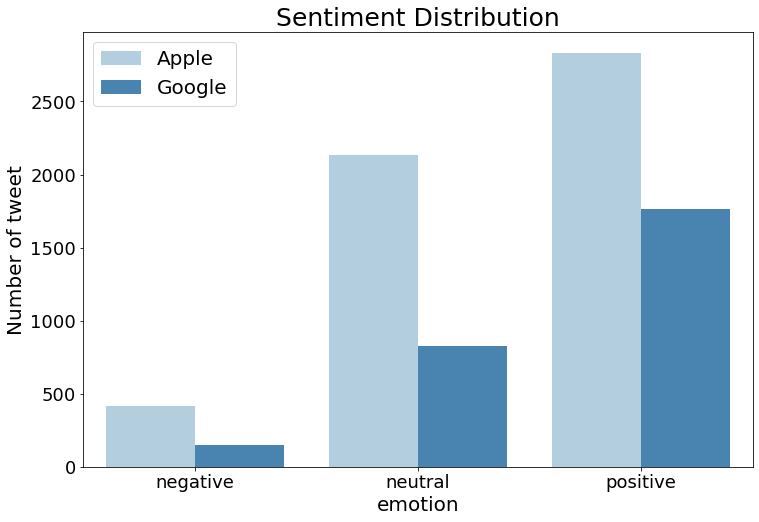

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
labels = ['negative','neutral','positive']
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.countplot(df_1['emotion'], hue=df_1['product'], palette='Blues')
plt.title('Sentiment Distribution', fontsize=25)
ax.set_yticklabels([0,500,1000,1500,2000,2500], fontsize=18)
ax.set_xticklabels(labels, fontsize=18)
plt.xlabel('emotion',fontsize=20)
plt.ylabel('Number of tweet',fontsize=20)
plt.legend(loc=2, prop={'size': 20})
plt.show()

The distribution plot shown above indicates that there is class imbalance between the product categories (Apple and Google) and the sentiments (positive,negative,neutral). This class imbalance can negatively affect the model performance and it will be resolved shortly. 

Finally, models require the target variable to be of integer type, so let's assign 0 to `Negative emotion`, 1 to `No emotion toward brand or product` and 2 to `Positive emotion`.

In [8]:
def number_map(x):
    if x == 'Positive emotion':
        return 2
    elif x == 'No emotion toward brand or product':
        return 1
    else:
        return 0

In [9]:
df_1['emotion'] = df_1['emotion'].apply(number_map)

Now that `emotion` and `product` columns are preprocessed, let's focus on preprocessing the `tweet_text` column. We'll start by using regex in order to filter some unimportant characters and phrases from tweets.

In [10]:
import re
# function to clean text
def cleaner(tweet):
    tweet = re.sub(r'@[A-Za-z0-9]+','', str(tweet)) # removes @
    tweet = re.sub(r'#', '', str(tweet)) # removes hashtag
    tweet = re.sub(r'RT[\s]+','', str(tweet)) # removes RT
    tweet = re.sub(r'https?:\/\/\S+', '', tweet) # remove hyperlink in tweet
    tweet = re.sub(r'[^\w\s]', '', tweet) # removes punctuations
    #tweet = re.sub(r'[^a-zA-Z]','', tweet)
    return tweet

df_1['tweet_text'] = df_1['tweet_text'].apply(cleaner)

Next, let's perform some feature engineering on the tweets. In the following cell, let's initiate the tokenizaton, stopword removal and lemmatization of the tweets. 

Tokenization will split each tweets into its respective words so that each word be analyzed by itself in the model. 

Stopword removal is necessary as stopwords are words that provide little to no sentiment value to the tweets. 

Lemmatization is needed as it allows to group words that are from the same root so that words that have the same meaning are considered the same. This way, the model is not hurt by needlessly increasing dimensionality.

In [11]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer


tokenizer = RegexpTokenizer(r"(?u)\w{3,}[a-zA-Z]")

stopwords_list = stopwords.words('english')

lemmatizer = WordNetLemmatizer()

def lemmatize_and_tokenize(text):
    tokens = tokenizer.tokenize(text)
    return [lemmatizer.lemmatize(token) for token in tokens]

Next, let's perform a train-test split.

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_1.drop('emotion',axis=1), df_1['emotion'], random_state=42)## TRAIN TEST SPLIT

Now that the dataset is cleaned, lemmatized and tokenized, it can now be converted into a vector format. In order to do so, TF-IDF vectorization will be used. This method is based on the idea that rare words are more valuable for prediction. The method utilizes two metrics:
* TF (term frequency) refers to the ratio of number of times a word appear in the document to the total number of words in the document. 
* IDF (Inverse Document Frequency) refers to the logged ratio of number of documents to the number of documents including the word.

In [13]:
# Import the relevant vectorizer class
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate a vectorizer with max_features=10
# (we are using the default token pattern)
tfidf = TfidfVectorizer(max_features=500, stop_words=stopwords_list, tokenizer=lemmatize_and_tokenize, strip_accents='ascii')

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train["tweet_text"])
# Visually inspect the vectorized data
X_train_df = pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

In [14]:
# transforming the test data
X_test_vectorized = tfidf.transform(X_test['tweet_text'])
X_test_df = pd.DataFrame.sparse.from_spmatrix(X_test_vectorized, columns=tfidf.get_feature_names())

It is time to deal with the class imbalance that was visualized earlier. `RandomOverSampler` will generate new samples for the minority class by duplicating samples from existing minority samples at random. This way, majority class stays intact. 

In [15]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [16]:
ros = RandomOverSampler(random_state=42)

# fit predictor and target variable
X_train_ros, y_train_ros = ros.fit_resample(X_train_vectorized, y_train)

print('Old shape of y:' + str(Counter(y_train)))
print('New shape of y:' + str(Counter(y_train_ros)))

Old shape of y:Counter({1: 3441, 2: 2233, 0: 423})
New shape of y:Counter({2: 3441, 1: 3441, 0: 3441})


In [17]:
# This cell converts the resampled vectorized data into a df
X_train_df = pd.DataFrame.sparse.from_spmatrix(X_train_ros, columns=tfidf.get_feature_names())

## MODELING

### Baseline Model: Logistic Regression

We decided to select a logistic regression with no hyperparameter tuning as the baseline classification model. Logistic regression was chosen as it is a simple classification algorithm and computationally efficient.

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix, accuracy_score
logreg = LogisticRegression()
logreg.fit(X_train_df, y_train_ros)
y_test_pred = logreg.predict(X_test_df)

Let's use cross-validation to observe how the baseline model does with unseen data.

In [19]:
# "np.mean" takes the average of 5 cross-validation scores
np.mean(cross_val_score(logreg,X_train_df, y_train_ros,cv=5, scoring = 'accuracy'))

0.6505888563545243

Let's look at the confusion matrix to see how the baseline model did on the test set.

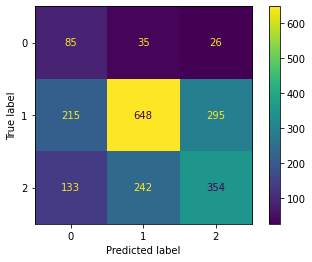

In [20]:
plot_confusion_matrix(logreg,X_test_df,y_test);

Finally, let's calculate the accuracy score of the baseline model on the test set.

In [21]:
accuracy_score(y_test,y_test_pred)

0.5346778160354156

The team decided to use accuracy as the performance metric for the models. This is the case as we give equal importance to correctly identifying each sentiment. This is because although it seems, from a business perspective, correctly identifying neutral and negative tweets is more important than correctly identifying positive sentiment tweets, these categories are codependent on each other as there are three sentiment categories. Every incorrect prediction of positive tweets will disrupt either neutral and negative tweet prediction, therefore, the team decided to use accuracy which gives equal importance to predicting each label correctly.

### Logistic Regression with Hyperparameter Tuning

Let's use `GridSearchCV` in order to try different hyperparameters to optimize the baseline logistic regression model.

In [22]:
from sklearn.model_selection import GridSearchCV

logreg1 = LogisticRegression()
param_grid =  {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

gs_logreg = GridSearchCV(logreg1, param_grid, cv=3, scoring='accuracy')
gs_logreg.fit(X_train_df, y_train_ros)
gs_logreg.best_params_

{'penalty': 'l2', 'solver': 'sag'}

Instantiate a new `LogisticRegression` model based on optimal parameters.

In [23]:
logreg2 = LogisticRegression(penalty = 'l2', solver = 'saga')
logreg2.fit(X_train_df, y_train_ros)

LogisticRegression(solver='saga')

Let's use cross-validation to observe how the tuned baseline model does with unseen data.

In [24]:
np.mean(cross_val_score(logreg2, X_train_df, y_train_ros,cv=5, scoring = 'accuracy'))

0.6511700640051054

Let's look at the confusion matrix to see how the tuned baseline model did on the test set.

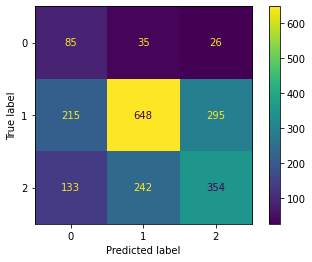

In [25]:
plot_confusion_matrix(logreg2,X_test_df,y_test);

Finally, let's calculate the accuracy score of the tuned baseline model on the test set.

In [26]:
y_test_pred = logreg2.predict(X_test_df)
accuracy_score(y_test,y_test_pred)

0.5346778160354156

Hyperparameter tuning did not improve the baseline model significantly. Let's move to a decision tree model and see how it does.

### Step Up Model: Decision Tree

We decided to use a decision tree as the step up model as it is also a simple classification algorithm that is computationally efficient and performs better at multiclass classifications compared to logistic regression. 

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix, accuracy_score
tree = DecisionTreeClassifier()
param_grid = { 'criterion':['gini','entropy'],
               'max_depth':[100,200,300]
}
gs_tree = GridSearchCV(tree, param_grid, cv=3, scoring='accuracy')
gs_tree.fit(X_train_df, y_train_ros)
gs_tree.best_params_

{'criterion': 'entropy', 'max_depth': 200}

Let's analyze the performance of the tuned decision tree model.

In [28]:
tree1 = DecisionTreeClassifier(criterion= 'entropy', max_depth = 200)
tree1.fit(X_train_df, y_train_ros)

DecisionTreeClassifier(criterion='entropy', max_depth=300)

Let's use cross-validation to observe how the tuned decision tree does with unseen data.

In [29]:
np.mean(cross_val_score(tree1,X_train_df, y_train_ros,cv=5, scoring = 'accuracy'))

0.7923147887456125

Let's look at the confusion matrix to see how the tuned decision tree did on the test set.

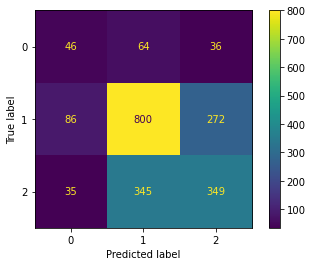

In [30]:
plot_confusion_matrix(tree1,X_test_df,y_test);

Finally, let's calculate the accuracy score of the tuned decision tree on the test set.

In [31]:
y_test_pred = tree1.predict(X_test_df)
accuracy_score(y_test,y_test_pred)

0.58780127889818

As it can be seen above, both the cross validation and test accuracy scores have improved significantly compared to logistic regression. 

## Final Model: Random Forest

We decided to use a random forest as the final model as random forest is an ensemble model which means it is more immune to overfitting and has stronger performance compared to decision trees. 

In [32]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()
param_grid = {'n_estimators':[50,100,200],
                'criterion':['gini','entropy']
}
gs_forest = GridSearchCV(forest, param_grid, cv=5, scoring='accuracy')
gs_forest.fit(X_train_df, y_train_ros)
gs_forest.best_params_

{'criterion': 'entropy', 'n_estimators': 100}

Let's analyze the performance of the tuned random forest model.

In [33]:
forest1 = RandomForestClassifier(n_estimators=200 , criterion = 'entropy')
forest1.fit(X_train_df, y_train_ros)

RandomForestClassifier(criterion='entropy', n_estimators=200)

Let's use cross-validation to observe how the tuned random forest does with unseen data.

In [34]:
np.mean(cross_val_score(forest1,X_train_df, y_train_ros,cv=5, scoring = 'accuracy'))

0.8171133885166206

Let's look at the confusion matrix to see how the tuned random forest did on the test set.

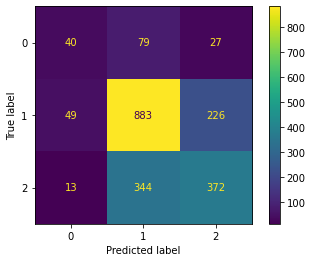

In [35]:
plot_confusion_matrix(forest1,X_test_df,y_test);

Finally, let's calculate the accuracy score of the tuned random forest on the test set.

In [36]:
y_test_pred = forest1.predict(X_test_df)
accuracy_score(y_test,y_test_pred)

0.6369896704377767

As it can be seen above, both the cross validation and test accuracy scores have improved significantly compared to decision tree. 

# Conclusion

The goal of this project was to come up with a method to perform sentiment analysis on tweets about Apple and Google products. In order to do so, we have created multiple classification models and identified the best one as a random forest model with an accuracy of 63%. This model will allow our stakeholder to identify the priority (negative and neutral) users and target their ads accordingly. 

We recommend that the stakeholder should focus on targeting Twitter users whose Tweets displayed either a neutral or negative sentiment towards Apple products. After all, they wouldn't want to lose customers based on one or two negative experiences they had. At the same time, we don’t want to risk losing customers who are neutral towards Apple products
Just like it’s important to bring in new customers, we think it’s just as important to retain the customers we have and keep them coming back to use our products. As for users that displayed a neutral or negative sentiment toward Google products, we see that as an opportunity to add to our current customer base. Targeting ads towards these users could convince them to ditch their Google products and see what they’re missing out on with Apple products.

# Future Research

Majority of tweets about Apple and Google products were either positive or neutral. More negative tweets should gathered in order to eliminate class imbalance without artificial methods. Also, focusing on specific Apple products that get more or less positive sentiment towards it. For example, maybe a specific Apple product like the iPad gets more positive tweets than another product. You can then advertise other Apple products like the Apple Watch or a Macbook to this user. 

Finally, the data also contains a fair amount of ‘retweets’. These tweets are repetitive, therefore we’d want to eliminate them in future research and replace them with original tweets.